In [4]:
!pip install pandas requests cartopy matplotlib pygplates ipywidgets jupyterlab_widgets

     ---------------------------------------- 11.1/11.1 MB 5.6 MB/s eta 0:00:00
     -------------------------------------- 509.2/509.2 KB 3.5 MB/s eta 0:00:00
     -------------------------------------- 347.8/347.8 KB 3.6 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\acer\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


✅ Raw fossils downloaded: 10000
🦴 Fossils in 110 ± 5 Ma: 670


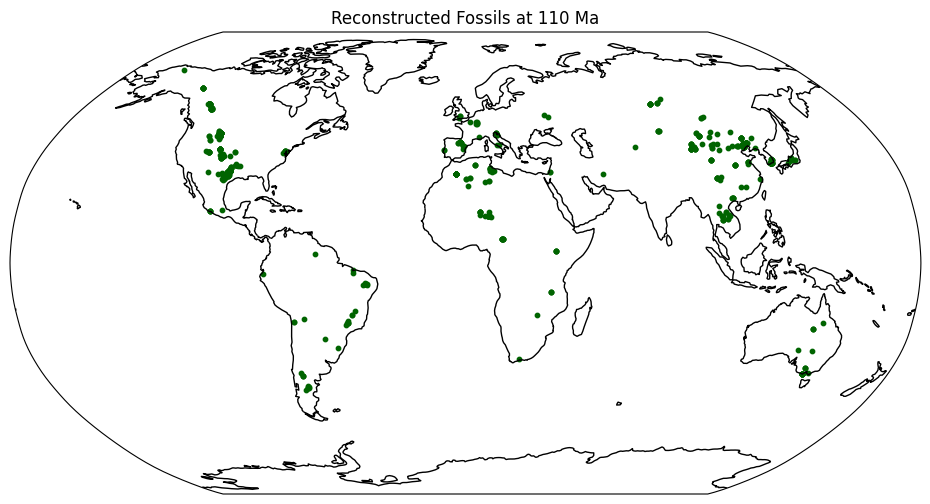

In [11]:
import pandas as pd
import requests
import pygplates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from io import StringIO

# === CONFIG ===
ROT_PATH = r'C:\Users\acer\paleofauna-model\GPlates 2.5.0\GeoData\FeatureCollections\AltPlateReconstructions\Muller_etal_2022\1000_0_rotfile.rot'
rotation_model = pygplates.RotationModel(ROT_PATH)

# === FETCH ===
def fetch_fossils(query_name='Theropoda', limit=10000):
    url = "https://paleobiodb.org/data1.2/occs/list.csv"
    params = {
        'base_name': query_name,
        'show': 'coords,time,phylo',
        'limit': limit
    }
    response = requests.get(url, params=params)
    df = pd.read_csv(StringIO(response.text))
    print(f"✅ Raw fossils downloaded: {len(df)}")

    df = df.dropna(subset=['lng', 'lat', 'max_ma', 'min_ma'])
    df = df.rename(columns={'max_ma': 'early_age', 'min_ma': 'late_age'})
    df['midpoint_ma'] = (df['early_age'] + df['late_age']) / 2

    return df

# === RECONSTRUCT ===
def reconstruct(df, window=5, center_time=110):
    filtered = df[
        (df['early_age'] >= center_time - window) &
        (df['late_age'] <= center_time + window)
    ]
    print(f"🦴 Fossils in {center_time} ± {window} Ma: {len(filtered)}")

    results = []

    for _, row in filtered.iterrows():
        point = pygplates.PointOnSphere(float(row['lat']), float(row['lng']))
        reconstruction_time = float(row['midpoint_ma'])

        try:
            # Create a feature with the point geometry
            feature = pygplates.Feature()
            feature.set_geometry(point)

            # Reconstruct the feature
            reconstructed = []
            pygplates.reconstruct([feature], rotation_model, reconstructed, reconstruction_time)

            if reconstructed:
                lat, lon = reconstructed[0].get_reconstructed_geometry().to_lat_lon()
                results.append((lon, lat))

        except Exception as e:
            print(f"❌ Error at {reconstruction_time} Ma: {e}")

    return results

# === PLOT ===
def plot_fossils(recon_coords, time=110):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    ax.set_global()
    ax.coastlines()
    lons, lats = zip(*recon_coords)
    ax.scatter(lons, lats, color='darkgreen', transform=ccrs.Geodetic(), s=10)
    ax.set_title(f'Reconstructed Fossils at {time} Ma')
    plt.show()

# === RUN ===
if __name__ == '__main__':
    df = fetch_fossils('Theropoda')
    coords = reconstruct(df, center_time=110)
    plot_fossils(coords, time=110)
